In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from layers import FreeSpacePropagation
import time
import pandas as pd
import cv2
from cxlayers import AngularSpectrum, ImageResizing, ImageToElectricField, ImageBinarization, CxMO, CxD2NNFaradayRotation, CxD2NNIntensity, D2NNMNISTDetector, Polarizer, GGG, Softmax
import glob


plt.rcParams["font.size"]=18

In [10]:
class CxD2NNFaradayRotation(tf.keras.layers.Layer):
    def __init__(self, output_dim, normalization=None, activation=None):
        super(CxD2NNFaradayRotation, self).__init__()
        self.output_dim = output_dim
        self.normalization = normalization
        self.activation = activation

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "normalization":  self.normalization,
            "activation": self.activation
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, x, **kwargs):
        rcp_x = tf.keras.layers.Lambda(lambda x:x[:,0,0,:,:])(x)
        rcp_y = tf.keras.layers.Lambda(lambda x:x[:,0,1,:,:])(x)
        lcp_x = tf.keras.layers.Lambda(lambda x:x[:,1,0,:,:])(x)
        lcp_y = tf.keras.layers.Lambda(lambda x:x[:,1,1,:,:])(x)

        E0 = rcp_x + lcp_x
        I0 = tf.abs(E0)**2 / 2.0
        E90 = rcp_y + lcp_y
        I90 = tf.abs(E90)**2 / 2.0
        E45_x = (rcp_x - rcp_y + lcp_x - lcp_y) / 2.0
        E45_y = (-rcp_x + rcp_y - lcp_x + lcp_y) / 2.0
        I45 = tf.abs(E45_x)**2/2 + tf.abs(E45_y)**2 / 2.0
        E135_x = (rcp_x + rcp_y + lcp_x + lcp_y) / 2.0
        E135_y = (rcp_x + rcp_y + lcp_x + lcp_y) / 2.0
        I135 = tf.abs(E135_x)**2/2 + tf.abs(E135_y)**2 / 2.0

        S1 = I0 - I90
        S2 = I45 - I135

        theta = tf.where(S1**2 > 1.0e-20, tf.atan(S2*S1 / S1**2) / 2.0, tf.atan(S2*S1 / 1.0e-20) / 2.0,)
        # theta = tf.atan((S2*S1 / S1**2)) / 2.0

        if self.normalization == 'minmax':
            minimum = tf.reduce_min(theta)
            maximum = tf.reduce_max(theta)
            theta = (theta - minimum) / (maximum - minimum)

        if self.activation == 'softmax':
            theta = tf.nn.softmax(theta)

        return theta

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

(array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
        1009.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

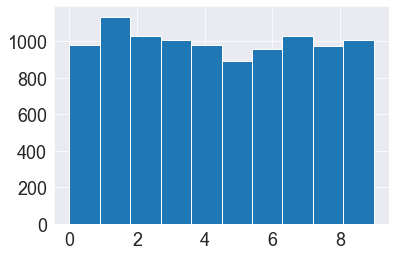

In [157]:
plt.hist(y_test)

In [4]:
train_num = 10
test_num = 10
total = train_num + test_num
train_data = {}
test_data = {}
for i in range(10):
  train_data[str(i)] = x_train[np.where(y_train == i)][0:train_num]
  test_data[str(i)] = x_test[np.where(y_test == i)][0:test_num]

In [11]:
shape = (100, 100)
inputs = tf.keras.Input((28, 28))
x = ImageResizing(shape)(inputs)
x = ImageBinarization(0.5, 0.0, 1.0)(x)
x = ImageToElectricField(shape)(x)
x = CxMO(shape, limitation=None, limitation_num=2.1 * np.pi / 180)(x)
x = AngularSpectrum(shape, wavelength=531e-9, z=1.0e-3, d=1.0e-6, method='expand')(x)
x = CxD2NNFaradayRotation(shape)(x)
# x = Polarizer(shape)(x)
# x = CxD2NNIntensity(shape)(x)
# x = D2NNMNISTDetector(10)(x)
# x = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs, x)

2022-04-21 21:35:25.749484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_23986/286719516.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


6.9649305


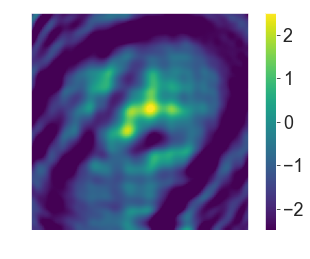

In [12]:
weights = model.layers[4].get_weights()
phase = ((np.loadtxt("data/phase/100px/train_7.csv")-0.5) * 2.0) * 2.1 * np.pi / 180
tx = np.linspace(-np.pi, np.pi, 100)
ty = np.linspace(-np.pi, np.pi, 100)
XX, YY = np.meshgrid(tx, ty)
W = np.sqrt(XX**2 + YY**2)
weights[0] = phase
model.layers[4].set_weights(weights)
image = np.ones((2, 28, 28))
pred = model.predict(image) * 180 / np.pi
plt.imshow(pred[0,:,:], cmap="viridis")
plt.colorbar()
plt.clim(-2.5, 2.5)
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)
plt.grid(False)
print(pred.max() - pred.min())

In [68]:
model = tf.keras.models.load_model("test")
model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_22 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 image_binarization_22 (Imag  (None, 100, 100)         0         
 eBinarization)                                                  
                                                                 
 image_to_electric_field_22   (None, 2, 2, 100, 100)   0         
 (ImageToElectricField)                                          
                                                                 
 cx_mo_12 (CxMO)             (None, 2, 2, 100, 100)    10002     
                                                          

(0,)


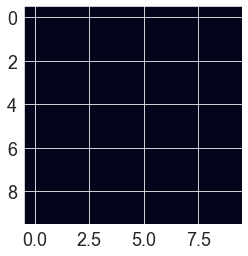

In [155]:
def check_zero_range(x, eps):
    return -eps < x < eps

e = np.arange(-5, 5, 1.0)
x = 10.0**e
XX, YY = np.meshgrid(x, x)

a = tf.constant(XX, dtype=tf.float16)
b = tf.constant(YY, dtype=tf.float16)
arg = 2.0 * tf.atan((tf.sqrt(a**2 + b**2) - a)/b)

print(arg[np.isnan((arg.numpy()))].shape)
plt.imshow(np.isnan(arg.numpy()))


<AxesSubplot:xlabel='epoch'>

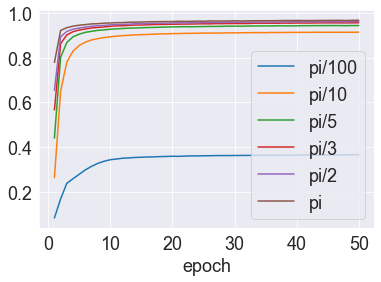

In [210]:
columns = ["epoch", "pi/100", "pi/10", "pi/5", "pi/3", "pi/2", "pi"]
path = "trained_model/20220415_*/*.csv"
files = glob.glob(path)
files.sort()
data = []
a = pd.read_csv(files[0])
for i, file in enumerate(files):
    df = pd.read_csv(file)
    if i == 0:
        data.append(df.index.values + 1)
    data.append(df["accuracy"].values)
data = pd.DataFrame(np.array(data).T, columns=columns)
data.plot(x="epoch")